In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'glove-embeddings:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F870709%2F1483651%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240127%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240127T074536Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0a58b260c7a59c923b717bff43ea4208586be583c1a1ad324e7bcb2e6ca7a3f5c8e5fa49e371f4d464b1b77679be58d0239a9766869c7badfca01f00cfcf21d7388bb22f5397daa6c01d04cdde509036975ca153fca9df676da77be865f68f859b8a8a013f1bccb8936ee84ac5750e3c8ea3c03864837c0c38ed1d84ba0219847d255ff715432534fbf76833841580c8b27720e32f2da636d32b906f82eddcb28def81056ffdbb6311d8fd20a219aa063a88e0177bca81c6b1a1708659cdc302b8ff3493f6d9ef98a3d5da0eea6bc237dcb6ca8eb5abb1307b75df3af62b195947447de970eacabece62c6ea28fb69f9673a52dcbbddec95b81816fecdf3d43f,flikr8k:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3231714%2F5620362%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240127%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240127T074536Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D73cf0bf77f3bc7b1dadc0690e94ae704a21b24d0aa5c27887ff0ab579fc73a9cbca8cbe44fc0a61a2100d95323eab90ad778cdb47a62a30dc897e8acdee35819395ca12ac1cbee38d143a58543de8205b10664bc296c80605a64b9379158967be0c0fb1fec480b86686d27e830ee688438d0f31e904a66ed8cec7e287d867338951be3ab8a51eb622f1cf984e96fe24468ed041a8847233848d03fbaa478bfeb818e97e6abca0afdecfb9b9a75ba3432046fa40a6b9c08cd3c631ae5a9898681a26753195ec1b9e7b273cd11009f46da6922a5716ae31052f91273872eed6a384c15b51dc14c2ff40983f477c6df316af11fcdddca977f29d81b51d53ad25673,pickledata-to-avoid-training:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4360967%2F7490319%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240127%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240127T074536Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4839ced1a8a9a182803bcc26d15705498c32187bf91ad496370e6ec0e58a231aef66a8f626bdadf1b4ca0b4509d8a31ccb5db711dd13607f11abbfe028acf40c19bd802b58070c0a60edd587295ae6a153ac214eaa2897074bcfa6c51dbe89d30c0823fd7d34e16a9aa6fc8be71584ab7ba8a6d0ef44584a3454225448e449296a50c5ef44f1465610b3e5d5f61f1fafc86a97335e442f26c23acd8ece77e0c620b994029f1c86663a464e7ac8181c34d11ccf3cf716263f9e8b3d73503d4e8aa7dc6b564bc3b74710d451e88f1a19a0c20030f3ff11e76c5d706fd4ea5820ebe5ee6768c51afafdc64b764eb0fac05ee9a0dc1bb6247f6ef61a17b04ffad896'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 885020669 bytes downloaded
Downloaded and uncompressed: glove-embeddings
[==================================================] 1114238055 bytes downloaded
Downloaded and uncompressed: flikr8k
[==================================================] 43287934 bytes downloaded
Downloaded and uncompressed: pickledata-to-avoid-training
Data source import complete.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import string
import re
import keras
from time import time

from keras.layers import add, Dense, Input, Dropout, Embedding, LSTM
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords

In [ ]:
token_txt_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr8k.token.txt'
train_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt'
test_img_path = '/kaggle/input/flikr8k/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt'

images_path = '/kaggle/input/flikr8k/Flickr8K/Flicker8k_Images/'

In [ ]:
def ReadTextFile(file):
    with open(file) as f:
        captions = f.read()
    return captions

captions = ReadTextFile(token_txt_path)
captions = captions.split('\n')[:-1]
print(len(captions))
print(captions[0])

40460
1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [ ]:
img_descriptions = {}

def imageWithText(captions):
    for d in captions:
        image_name, caption = d.split('\t')
        image_name = image_name.split('.')[0]

        if img_descriptions.get(image_name) is None:
            img_descriptions[image_name] = []

        img_descriptions[image_name].append(caption)


imageWithText(captions)
del(img_descriptions['2258277193_586949ec62'])

In [ ]:
print(len(img_descriptions))
print(img_descriptions['1000268201_693b08cb0e'])

img = images_path + '1000268201_693b08cb0e.jpg'
img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
# check if any of the image in token.txt images is not exists in 8k_images
for t in img_descriptions.keys():
    p = os.path.join(images_path, t + '.jpg')
    if not os.path.isfile(p):
        print(t)

In [ ]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub('[^a-z]+', " ", sentence)
    sentence = sentence.split()

    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

# clean_text("A cat is sitting in room no hello64")

for k, caption_list in img_descriptions.items():
    for c in range(len(caption_list)):
        caption_list[c] = clean_text(caption_list[c])

print(img_descriptions['1000268201_693b08cb0e'])

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [ ]:
with open('/kaggle/working/descriptions.txt', 'w') as f:
    f.write(str(img_descriptions))

In [ ]:
descriptions = {}
with open('/kaggle/working/descriptions.txt', 'r') as f:
    descriptions = f.read()

descriptions = json.loads(descriptions.replace("'", "\""))

In [ ]:
print(type(descriptions))

<class 'dict'>


In [ ]:
vocab = set()
for k in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[k]]

print(len(vocab))

8424


In [ ]:
Total_words = []

for k in descriptions.keys():
    [Total_words.append(i) for sentence in descriptions[k] for i in sentence.split()]

print(len(Total_words))

373803


In [ ]:
import collections

counter = collections.Counter(Total_words)
freq_count = dict(counter)
# print(freq_count)
print(len(freq_count))

8424


In [ ]:
sorted_freq_cnt = sorted(freq_count.items(), reverse=True, key=lambda x: x[1])

threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
Total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
len(Total_words)

1845

In [ ]:
train_file_data = ReadTextFile(train_img_path)
test_file_data = ReadTextFile(test_img_path)

In [ ]:
train = [r.split('.')[0] for r in train_file_data.split("\n")[:-1]]
test = [r.split('.')[0] for r in test_file_data.split("\n")[:-1]]

In [ ]:
len(train), len(test), train[:10], test[:10]

In [ ]:
demo_img = '2513260012_03d33305cf'

In [ ]:
train_descriptions = {}
for t in train:
    train_descriptions[t] = []
    for sent in descriptions[t]:
        sent = 'startseq ' + sent + ' endseq'
        train_descriptions[t].append(sent)

Total_words.append('startseq')
Total_words.append('endseq')
print(train_descriptions['2513260012_03d33305cf'])
vocab_size = len(Total_words) + 1
print(vocab_size)

['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']
1848


### **Transfer learning**
- Image -> features
- Text -> features

In [ ]:
model = ResNet50(weights='imagenet', input_shape=(224,224,3))
model.summary()

In [ ]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [ ]:
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

In [ ]:
def preprocess_img(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    img = preprocess_input(img)
    return img

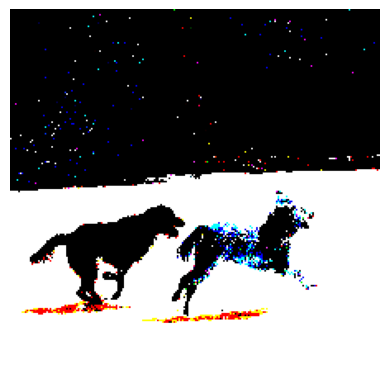

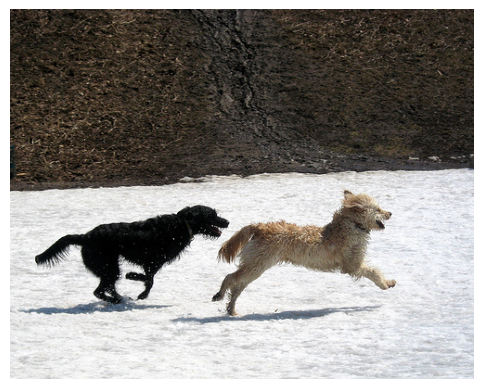

In [ ]:
img = preprocess_img(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img[0])
plt.axis('off')
plt.show()
img = plt.imread(images_path + '2513260012_03d33305cf.jpg')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
def encode_images(img_path):
    img = preprocess_img(img_path)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1, ))
    return feature_vector

encode_images(images_path + '2513260012_03d33305cf.jpg').shape

1/1 [==============================] - 4s 4s/step


(2048,)

In [ ]:
# %%capture
def encoding_data(data):
    start = time()
    encoding_train = {}

    for i, img_id in enumerate(data):
        encoding_train[img_id] = encode_images(images_path + img_id + '.jpg')
        if i%100 == 0:
            print('Encoding in progress %d step'%i)

    end_t = time()
    print("Total time taken: ",end_t - start)
    return encoding_train

In [ ]:
# train with resnet50 for all training images and obtain vector(2048,)

encoding_train = encoding_data(train)
encoding_test = encoding_data(test)

with open('encoded_train_features.pkl', 'wb') as f:
    pickle.dump(encoding_train, f)

with open('encoded_test_features.pkl', 'wb') as f:
    pickle.dump(encoding_test, f)

In [ ]:
# Can reuse encoded data from pickle files to avoid obtaining ResNet50 image vector repeatedly.

encoded_test_path = '/kaggle/input/pickledata-to-avoid-training/encoded_test_features.pkl'
encoded_train_path = '/kaggle/input/pickledata-to-avoid-training/encoded_train_features.pkl'

encoding_train, encoding_test = None, None

with open(encoded_train_path, 'rb') as f:
    encoding_train = pickle.load(f)


with open(encoded_test_path, 'rb') as f:
    encoding_test = pickle.load(f)

In [ ]:
word_2_idx = {}
idx_2_word = {}

for i, word in enumerate(Total_words):
    word_2_idx[word] = i + 1
    idx_2_word[i + 1] = word

with open("word_2_idx.pkl", 'wb') as f:
  pickle.dump(word_2_idx, f)

with open("idx_2_word.pkl", 'wb') as f:
  pickle.dump(idx_2_word, f)

In [ ]:
max_len = 0
for values in train_descriptions.values():
    for sent in values:
        max_len = max(max_len, len(sent.split()))
print(max_len)

35


### **Custom Data Generator**

In [ ]:
def data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size=32):
    x1, x2, y = [],[],[]
    n = 0

    while True:
        for k, value_list in train_descriptions.items():
            n += 1
            photo = encoding_train[k]

            for sent in value_list:
                seq = [word_2_idx[w] for w in sent.split() if w in word_2_idx]

                for i in range(1, len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]

                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
#                     print("xi shape: ",np.array(xi).shape)
#                     print("yi shape: ",np.array(yi).shape)

                    x1.append(photo)
                    x2.append(xi)
                    y.append(yi)
#                     print("x1 shape: ",np.array(x1).shape)
#                     print("x2 shape: ",np.array(x2).shape)
#                     print("y shape: ",np.array(y).shape)

            if n == batch_size:
                yield [np.array(x1), np.array(x2)], np.array(y)
                x1,x2,y = [],[],[]
                n = 0

### **Word Embeddings**

In [ ]:
f = open('/kaggle/input/glove-embeddings/glove.6B.50d.txt')

embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding = np.array(values[1:], dtype='float')
    embedding_index[word] = word_embedding

f.close()

In [ ]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))

    for word, index in word_2_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            matrix[index] = embedding_vector

    return matrix


embedding_matrix = get_embedding_matrix()
print(embedding_matrix.shape)

(1848, 50)


In [ ]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)


input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[input_img_features, input_captions], outputs=outputs)
model.summary()

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
batch_size = 3
epochs = 20
steps = len(train_descriptions)

In [ ]:
def train():
    for e in range(epochs):
        generator = data_generator(train_descriptions, encoding_train, word_2_idx, max_len, batch_size)
        print("here: ", model.output_shape)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save('/kaggle/working/models/models_'+str(e)+".h5")

train()

In [ ]:
# download

from google.colab import files
fls = os.listdir('/kaggle/working/models/')
for f in fls:
  files.download('/kaggle/working/models/'+f)

print(fls)

In [ ]:
model = load_model('/models_19.h5')

def predict_caption(photo, max_len, word_2_idx, idx_2_word):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_2_idx[w] for w in in_text.split() if w in word_2_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')[0]
        sequence = np.expand_dims(sequence, axis=0)
        ypred = model.predict([photo, sequence])
        ypred = ypred.argmax(axis=-1)[0]
        word = idx_2_word[ypred]
        in_text += (' ' + word)
        if word == "endseq":
            break
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

1/1 [==============================] - 0s 33ms/step


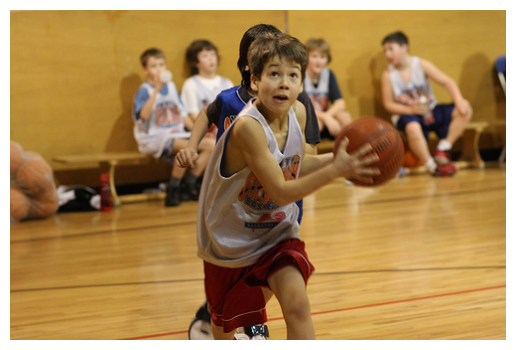

two men in white and orange basketball uniforms are playing basketball
1/1 [==============================] - 0s 56ms/step


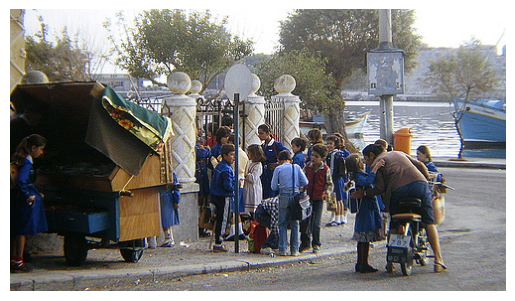

two men are riding bicycles on the street
1/1 [==============================] - 0s 19ms/step


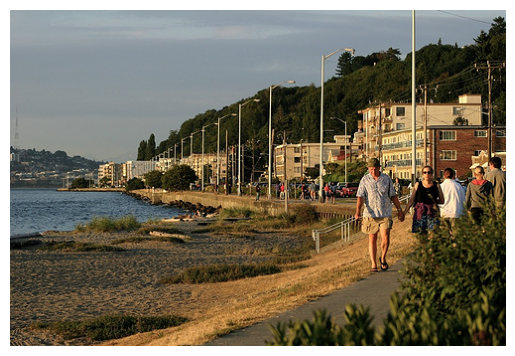

cloudy day to catch the view in the water
1/1 [==============================] - 0s 18ms/step


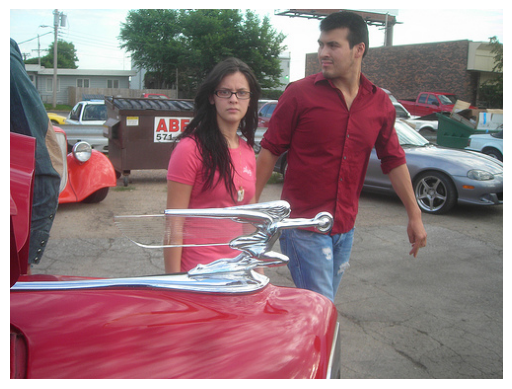

man in red shirt and cap is riding motorcycle
1/1 [==============================] - 0s 35ms/step


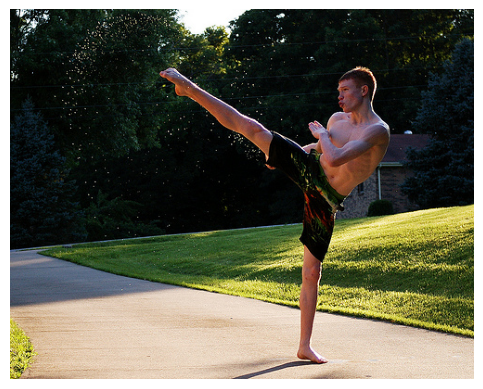

man in red shirt and blue shorts is throwing ball in his hand
1/1 [==============================] - 0s 45ms/step


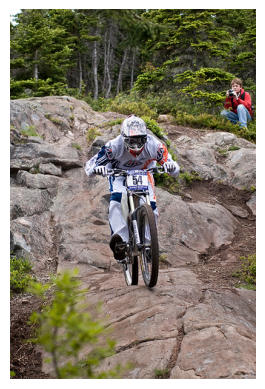

man on motorcycle riding down rocky hill
1/1 [==============================] - 0s 22ms/step


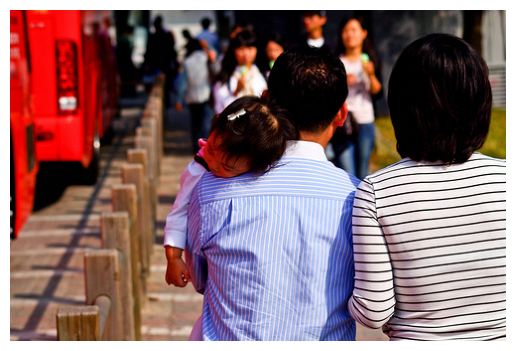

man in red shirt is wearing red number carrying skateboard
1/1 [==============================] - 0s 22ms/step


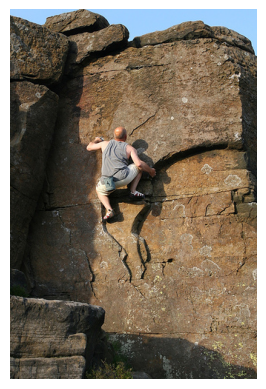

man climbing rock wall
1/1 [==============================] - 0s 27ms/step


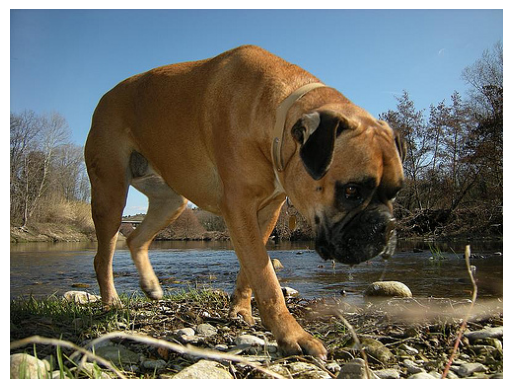

brown dog is running on the grass
1/1 [==============================] - 0s 27ms/step


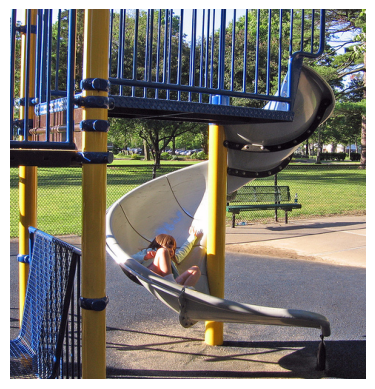

man in black shirt is jumping off of ledge
1/1 [==============================] - 0s 27ms/step


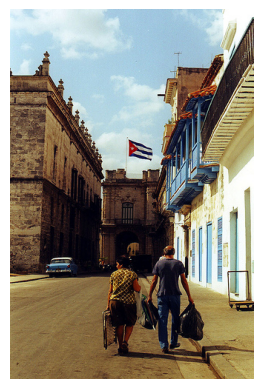

man in blue shirt and blue shorts is crossing open where onlookers
1/1 [==============================] - 0s 27ms/step


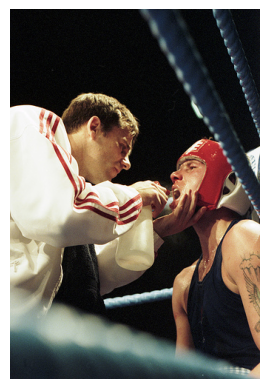

man in blue shirt and gold shorts is grabbing the basketball in the air
1/1 [==============================] - 0s 28ms/step


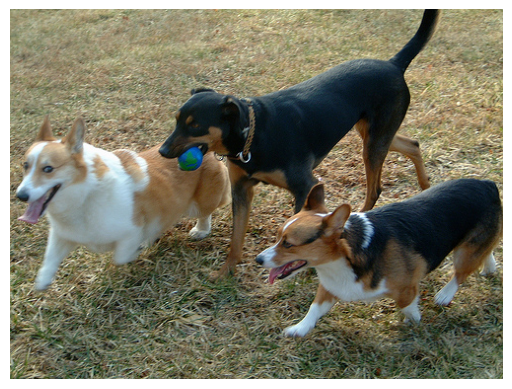

two dogs are playing together in the grass
1/1 [==============================] - 0s 31ms/step


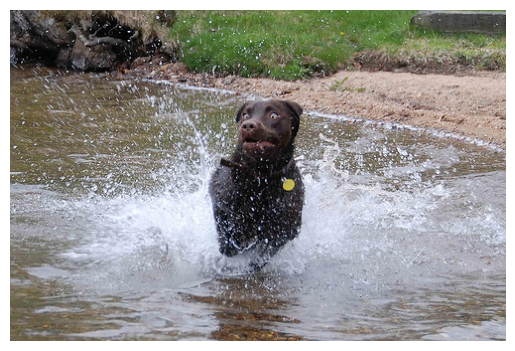

black dog is running through the water
1/1 [==============================] - 0s 28ms/step


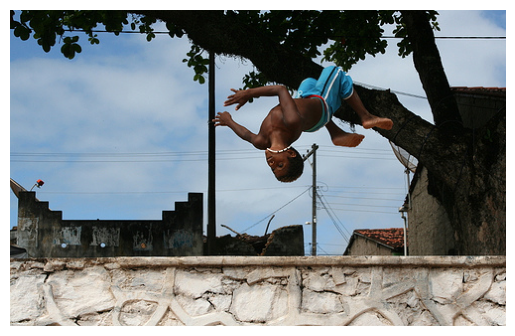

man is flipping on his skateboard in the air


In [ ]:
for i in range(15):
    idx = np.random.randint(0, 1000)
    test_imgs = list(encoding_test.keys())
    test_img = test_imgs[idx]
    photo = encoding_test[test_img].reshape((1, 2048))
    img = plt.imread(images_path + test_img + '.jpg')
    caption = predict_caption(photo, max_len, word_2_idx, idx_2_word)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print(caption)